In [305]:
import numpy as np
import json
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import gc
from transformers import BertTokenizer , BertModel
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
import wandb
from sklearn.metrics import classification_report, confusion_matrix
import plotly.figure_factory as ff

In [352]:
with open('./data/Intent.json') as f:
    data_en = json.load(f)

In [306]:
with open('./data/IntentPortuguese.json') as f:
    data = json.load(f)

In [307]:
with open('./data/TestsPortuguese.json') as f:
    tests_data = json.load(f)

In [308]:
wandb.init(project='intent_recognition')

# Configuration

In [309]:
class cfg:
    num_classes=28
    epochs=20
    batch_size=10
    lr=1e-5
    max_length=20

In [310]:
config = wandb.config          # Acede ao objeto de configuração
config.learning_rate = cfg.lr
config.epochs = cfg.epochs
config.batch_size = cfg.batch_size

# Here we define our training dataframe

In [ ]:
df = pd.DataFrame(data['intents'])
df.head()

,intent,text,responses,extension,context,entityType,entities
0,Saudação,"[Oi, Oi lá, Olá, Alô, Alô lá, Ei, Ei lá, Eai]","[Oi humano, por favor, diga-me seu nome, Olá h...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'PedidoUsuárioSaudação', 'cl...",NA,[]
1,RespostaSaudação,"[Adam, Bella, Meu usuário é Adam, Me chamo Ada...","[Ótimo! Oi <HUMANO>! Como posso ajudar?, Bom! ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'PedidoUsuárioSaudação', 'out': '', 'cl...",NA,"[{'entity': 'HUMANO', 'rangeFrom': 3, 'rangeTo..."
2,SaudaçãoCortesia,"[Como vai?, Oi, como vai?, Olá, como vai?, Olá...","[Olá, estou ótimo, e você? Por favor, diga-me ...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'PedidoUsuárioSaudaçãoCortes...",NA,[]
3,RespostaSaudaçãoCortesia,"[Bem, obrigado! Meu usuário é Adam, Bem, obrig...","[Ótimo! Oi <HUMANO>! Como posso ajudar?, Bom! ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'PedidoUsuárioSaudação', 'out': '', 'cl...",NA,"[{'entity': 'HUMANO', 'rangeFrom': 5, 'rangeTo..."
4,ConsultaHumanoAtual,"[Qual é o meu nome?, Como você me chama?, Quem...","[Você é <HUMANO>! Como posso ajudar?, Seu nome...",{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'ConsultaHumanoAtual', 'clea...",NA,[]


In [312]:
df_patterns = df[['text', 'intent']]
df_responses = df[['responses', 'intent']]
df_patterns.head()

,text,intent
0,"[Oi, Oi lá, Olá, Alô, Alô lá, Ei, Ei lá, Eai]",Saudação
1,"[Adam, Bella, Meu usuário é Adam, Me chamo Ada...",RespostaSaudação
2,"[Como vai?, Oi, como vai?, Olá, como vai?, Olá...",SaudaçãoCortesia
3,"[Bem, obrigado! Meu usuário é Adam, Bem, obrig...",RespostaSaudaçãoCortesia
4,"[Qual é o meu nome?, Como você me chama?, Quem...",ConsultaHumanoAtual


In [313]:
df_patterns = df_patterns.explode('text')
df_patterns.head()

,text,intent
0,Oi,Saudação
0,Oi lá,Saudação
0,Olá,Saudação
0,Alô,Saudação
0,Alô lá,Saudação


# Here we define our test dataframe

In [314]:
df_test = pd.DataFrame(tests_data['intents'])
df_test.head()

,intent,text
0,Saudação,"[Olá, como você está?, E aí, tudo bem?, Boa ta..."
1,RespostaSaudação,"[Eu me chamo Carlos, Meu nome é Julia, Paulo f..."
2,SaudaçãoCortesia,"[Tudo bem por aí?, Você está bem hoje?, Espero..."
3,RespostaSaudaçãoCortesia,"[Estou ótimo, obrigado. Me chamo Henrique., Eu..."
4,ConsultaHumanoAtual,"[Poderia confirmar quem sou?, Esqueci, como vo..."


In [315]:
test_patterns = df_test[['text', 'intent']]
test_patterns.head()

,text,intent
0,"[Olá, como você está?, E aí, tudo bem?, Boa ta...",Saudação
1,"[Eu me chamo Carlos, Meu nome é Julia, Paulo f...",RespostaSaudação
2,"[Tudo bem por aí?, Você está bem hoje?, Espero...",SaudaçãoCortesia
3,"[Estou ótimo, obrigado. Me chamo Henrique., Eu...",RespostaSaudaçãoCortesia
4,"[Poderia confirmar quem sou?, Esqueci, como vo...",ConsultaHumanoAtual


In [316]:
test_patterns = test_patterns.explode('text')
test_patterns.head()

,text,intent
0,"Olá, como você está?",Saudação
0,"E aí, tudo bem?",Saudação
0,"Boa tarde, tudo em ordem?",Saudação
0,"Saudações, como posso ser assistido?",Saudação
0,"Oi oi, como vai?",Saudação


## Here is the count distribution of the given intents

22


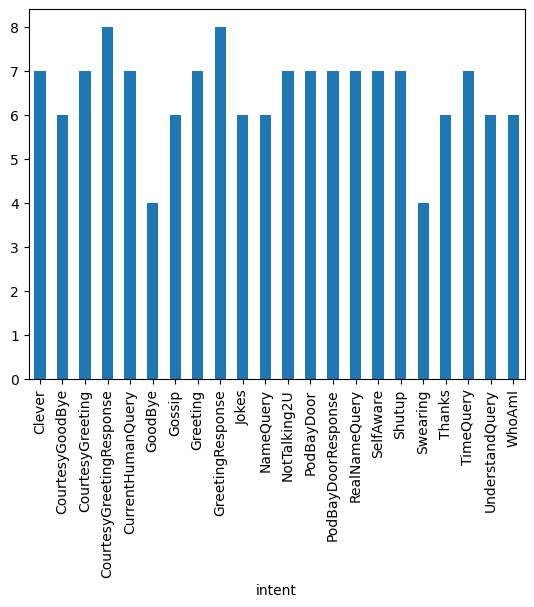

In [354]:
df_eng = pd.DataFrame(data_en['intents'])
s=set(list(df_eng['intent']))
print(len(s))
df_patterns_eng = df_eng[['text', 'intent']]
df_patterns_eng = df_patterns_eng.explode('text')
df_patterns_eng.groupby(['intent']).size().plot.bar()
# Obtém o limite atual do eixo y
y_max = plt.ylim()[1]

# Define novos ticks para o eixo y, garantindo que todos sejam inteiros
plt.yticks(range(0, int(y_max)+1, 1))

plt.show()

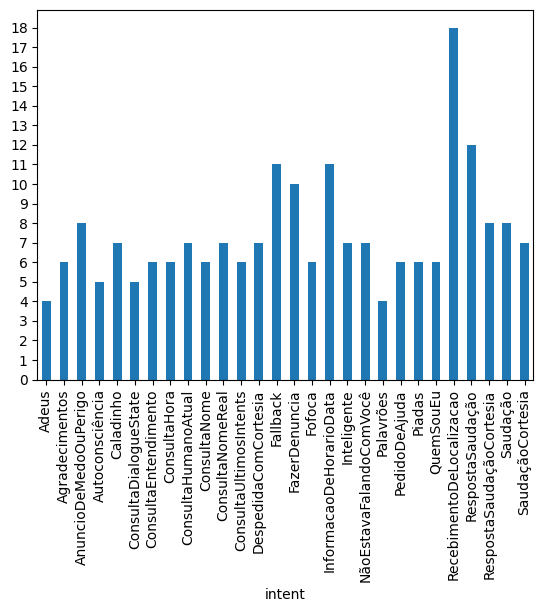

In [317]:
df_patterns.groupby(['intent']).size().plot.bar()
# Obtém o limite atual do eixo y
y_max = plt.ylim()[1]

# Define novos ticks para o eixo y, garantindo que todos sejam inteiros
plt.yticks(range(0, int(y_max)+1, 1))

plt.show()

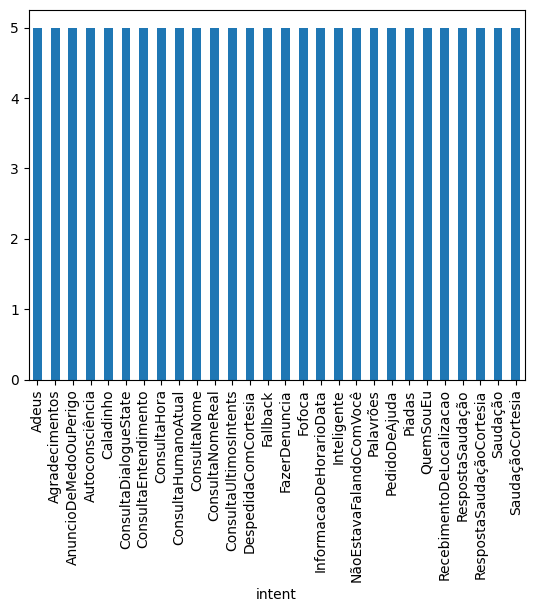

In [318]:
test_patterns.groupby(['intent']).size().plot.bar()
# Obtém o limite atual do eixo y
y_max = plt.ylim()[1]

# Define novos ticks para o eixo y, garantindo que todos sejam inteiros
plt.yticks(range(0, int(y_max)+1, 1))

plt.show()

In [319]:
df=df_patterns.copy()

In [320]:
test=test_patterns.copy()

## Defining the labels

In [321]:
s=set(list(df['intent']))
j=0
labels={}
for i in s:
    labels[i]=j
    j+=1


In [322]:
len(labels)

28

In [323]:
labels

{'FazerDenuncia': 0,
 'ConsultaEntendimento': 1,
 'DespedidaComCortesia': 2,
 'InformacaoDeHorarioData': 3,
 'Fallback': 4,
 'RespostaSaudaçãoCortesia': 5,
 'ConsultaUltimosIntents': 6,
 'Saudação': 7,
 'Autoconsciência': 8,
 'Caladinho': 9,
 'ConsultaDialogueState': 10,
 'Piadas': 11,
 'SaudaçãoCortesia': 12,
 'PedidoDeAjuda': 13,
 'NãoEstavaFalandoComVocê': 14,
 'Adeus': 15,
 'ConsultaHumanoAtual': 16,
 'ConsultaNomeReal': 17,
 'ConsultaHora': 18,
 'RespostaSaudação': 19,
 'RecebimentoDeLocalizacao': 20,
 'Inteligente': 21,
 'Agradecimentos': 22,
 'ConsultaNome': 23,
 'Fofoca': 24,
 'QuemSouEu': 25,
 'Palavrões': 26,
 'AnuncioDeMedoOuPerigo': 27}

# Here we define the tokenizer and our dataset

In [324]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')


class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['intent']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = cfg.max_length, truncation=True,
                                return_tensors="pt") for text in df['text']]


    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

# For intent classification , we are going to be using a bert model followed by a linear layer

In [325]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.2):

        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, cfg.num_classes)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)


        return (linear_output)

# Splitting the data into training and validation

In [326]:
df_train, df_val = np.split(df.sample(frac=1, random_state=42), [int(.9*len(df))])

print(len(df_train), len(df_val))

186 21


/opt/miniconda3/envs/intent/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



# The training and evaluation loop

In [327]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=cfg.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=cfg.batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=cfg.lr)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()
            
    best_val_loss = float('inf') 
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                
                train_label=train_label.to(device)
                output=output.to(device)
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

                wandb.log({"train_loss": batch_loss.item()})
            wandb.log({"train_accuracy": total_acc_train / len(train_data)})
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)
                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                wandb.log({"val_loss": total_loss_val / len(val_data), "val_accuracy": total_acc_val / len(val_data)})
            avg_val_loss = total_loss_val / len(val_data)

            if avg_val_loss < best_val_loss:  # Verifica se a média da perda atual é a melhor
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), 'model_best_val_loss.pth')  # Salva o modelo
                print(f"Checkpoint saved on epoch {epoch_num + 1} with val/loss {best_val_loss:.4f}")
                    
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  


### to free up memory

In [328]:
gc.collect()

24457

In [329]:
EPOCHS = cfg.epochs
model = BertClassifier()
LR = cfg.lr
              
train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 19/19 [00:10<00:00,  1.85it/s]


Checkpoint saved on epoch 1 with val/loss 0.4685
Epochs: 1 | Train Loss:  0.342                 | Train Accuracy:  0.048                 | Val Loss:  0.468                 | Val Accuracy:  0.000


100%|██████████| 19/19 [00:08<00:00,  2.20it/s]


Epochs: 2 | Train Loss:  0.328                 | Train Accuracy:  0.091                 | Val Loss:  0.475                 | Val Accuracy:  0.000


100%|██████████| 19/19 [00:08<00:00,  2.26it/s]


Checkpoint saved on epoch 3 with val/loss 0.4372
Epochs: 3 | Train Loss:  0.316                 | Train Accuracy:  0.231                 | Val Loss:  0.437                 | Val Accuracy:  0.238


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Checkpoint saved on epoch 4 with val/loss 0.4311
Epochs: 4 | Train Loss:  0.300                 | Train Accuracy:  0.366                 | Val Loss:  0.431                 | Val Accuracy:  0.238


100%|██████████| 19/19 [00:10<00:00,  1.88it/s]


Checkpoint saved on epoch 5 with val/loss 0.4136
Epochs: 5 | Train Loss:  0.280                 | Train Accuracy:  0.505                 | Val Loss:  0.414                 | Val Accuracy:  0.381


100%|██████████| 19/19 [00:10<00:00,  1.79it/s]


Checkpoint saved on epoch 6 with val/loss 0.4057
Epochs: 6 | Train Loss:  0.259                 | Train Accuracy:  0.645                 | Val Loss:  0.406                 | Val Accuracy:  0.429


100%|██████████| 19/19 [00:09<00:00,  2.01it/s]


Checkpoint saved on epoch 7 with val/loss 0.3852
Epochs: 7 | Train Loss:  0.236                 | Train Accuracy:  0.747                 | Val Loss:  0.385                 | Val Accuracy:  0.524


100%|██████████| 19/19 [00:10<00:00,  1.89it/s]


Checkpoint saved on epoch 8 with val/loss 0.3656
Epochs: 8 | Train Loss:  0.214                 | Train Accuracy:  0.844                 | Val Loss:  0.366                 | Val Accuracy:  0.667


100%|██████████| 19/19 [00:09<00:00,  1.94it/s]


Checkpoint saved on epoch 9 with val/loss 0.3508
Epochs: 9 | Train Loss:  0.192                 | Train Accuracy:  0.898                 | Val Loss:  0.351                 | Val Accuracy:  0.667


100%|██████████| 19/19 [00:09<00:00,  1.99it/s]


Checkpoint saved on epoch 10 with val/loss 0.3314
Epochs: 10 | Train Loss:  0.170                 | Train Accuracy:  0.935                 | Val Loss:  0.331                 | Val Accuracy:  0.619


100%|██████████| 19/19 [00:09<00:00,  1.97it/s]


Checkpoint saved on epoch 11 with val/loss 0.3088
Epochs: 11 | Train Loss:  0.151                 | Train Accuracy:  0.952                 | Val Loss:  0.309                 | Val Accuracy:  0.714


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Checkpoint saved on epoch 12 with val/loss 0.2982
Epochs: 12 | Train Loss:  0.135                 | Train Accuracy:  0.952                 | Val Loss:  0.298                 | Val Accuracy:  0.667


100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


Checkpoint saved on epoch 13 with val/loss 0.2884
Epochs: 13 | Train Loss:  0.119                 | Train Accuracy:  0.973                 | Val Loss:  0.288                 | Val Accuracy:  0.762


100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Checkpoint saved on epoch 14 with val/loss 0.2764
Epochs: 14 | Train Loss:  0.107                 | Train Accuracy:  0.984                 | Val Loss:  0.276                 | Val Accuracy:  0.714


100%|██████████| 19/19 [00:08<00:00,  2.15it/s]


Checkpoint saved on epoch 15 with val/loss 0.2666
Epochs: 15 | Train Loss:  0.094                 | Train Accuracy:  0.995                 | Val Loss:  0.267                 | Val Accuracy:  0.714


100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Checkpoint saved on epoch 16 with val/loss 0.2578
Epochs: 16 | Train Loss:  0.084                 | Train Accuracy:  0.995                 | Val Loss:  0.258                 | Val Accuracy:  0.762


100%|██████████| 19/19 [00:09<00:00,  2.07it/s]


Checkpoint saved on epoch 17 with val/loss 0.2528
Epochs: 17 | Train Loss:  0.076                 | Train Accuracy:  0.989                 | Val Loss:  0.253                 | Val Accuracy:  0.810


100%|██████████| 19/19 [00:09<00:00,  2.11it/s]


Checkpoint saved on epoch 18 with val/loss 0.2311
Epochs: 18 | Train Loss:  0.068                 | Train Accuracy:  0.995                 | Val Loss:  0.231                 | Val Accuracy:  0.810


100%|██████████| 19/19 [00:09<00:00,  2.06it/s]


Checkpoint saved on epoch 19 with val/loss 0.2227
Epochs: 19 | Train Loss:  0.061                 | Train Accuracy:  1.000                 | Val Loss:  0.223                 | Val Accuracy:  0.810


100%|██████████| 19/19 [00:10<00:00,  1.89it/s]


Epochs: 20 | Train Loss:  0.055                 | Train Accuracy:  1.000                 | Val Loss:  0.229                 | Val Accuracy:  0.810


In [330]:
wandb.finish()

train_accuracy,▁▁▂▃▄▅▆▇▇███████████
train_loss,█████▇▇█▇▇▇▇▆▅▆▆▅▆▅▅▄▄▄▃▃▃▃▃▃▃▃▁▂▂▂▂▁▁▁▁
val_accuracy,▁▁▃▃▄▅▆▇▇▆▇▇█▇▇█████
val_loss,██▇▇▆▆▆▅▅▄▃▃▃▂▂▂▂▁▁▁
train_accuracy,1
train_loss,0.3334
val_accuracy,0.80952
val_loss,0.22857


In [331]:
# O caminho para o arquivo JSON que será criado
filepath = 'data/labels.json'

# Abrindo o arquivo para escrita ('w') e salvando o dicionário usando json.dump
with open(filepath, 'w', encoding='utf-8') as f:
    json.dump(labels, f, ensure_ascii=False, indent=4)

# Evaluating on test set

In [336]:
checkpoint_path = 'checkpoints/model_best_val_loss_28.pth'
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)

/var/folders/qc/40cp3vzn26dgkntppc0jv9tc0000gn/T/ipykernel_12649/150644189.py:4: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [337]:
def evaluate(model, dataloader):
    model.eval()
    
    predictions = []
    true_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            mask = inputs['attention_mask'].to(device)
            input_id = inputs['input_ids'].squeeze(1).to(device)
            outputs = model(input_id,mask)  # Supondo que sua saída do modelo são logits.

            # Para modelos de classificação, assumimos uma saída softmax.
            probs = torch.nn.functional.softmax(outputs, dim=1)
            predicted_labels = torch.argmax(probs, dim=1)

            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return true_labels, predictions

In [338]:
test = Dataset(test_patterns)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False) 

In [339]:
true_labels, predictions = evaluate(model, test_dataloader)

# Gerar relatório de classificação
report = classification_report(true_labels, predictions, target_names=labels)
print(report)

                          precision    recall  f1-score   support

           FazerDenuncia       0.56      1.00      0.71         5
    ConsultaEntendimento       0.00      0.00      0.00         5
    DespedidaComCortesia       0.50      1.00      0.67         5
 InformacaoDeHorarioData       1.00      1.00      1.00         5
                Fallback       0.40      0.80      0.53         5
RespostaSaudaçãoCortesia       0.43      0.60      0.50         5
  ConsultaUltimosIntents       1.00      1.00      1.00         5
                Saudação       0.00      0.00      0.00         5
         Autoconsciência       0.83      1.00      0.91         5
               Caladinho       1.00      0.80      0.89         5
   ConsultaDialogueState       1.00      1.00      1.00         5
                  Piadas       0.56      1.00      0.71         5
        SaudaçãoCortesia       0.25      0.40      0.31         5
           PedidoDeAjuda       0.67      0.80      0.73         5
 NãoEstav

/opt/miniconda3/envs/intent/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/envs/intent/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/envs/intent/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [340]:
cm = confusion_matrix(true_labels, predictions)

In [341]:
labels_names = list(labels.keys())

In [342]:
labels_cm = [str(i) for i in range(1, cm.shape[0] + 1)]
fig = ff.create_annotated_heatmap(z=cm, x=labels_names, y=labels_names, colorscale='Viridis', 
                                   annotation_text=cm.astype(str), showscale=True)
fig.update_layout(title_text='Matriz de Confusão', xaxis=dict(title='Previsão'), yaxis=dict(title='Real'), yaxis_autorange='reversed')

fig.write_html('cm.html')

# Predicting ouput for a given text

In [343]:
def predict(model, text):
    print(text)
    text_dict = tokenizer(text, padding='max_length', max_length = cfg.max_length, truncation=True, return_tensors="pt")
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = model.to(device)
    mask = text_dict['attention_mask'].to(device)
    input_id = text_dict['input_ids'].squeeze(1).to(device)
        
    with torch.no_grad():
        output = model(input_id, mask)
        
        # Aplica softmax para converter logits em probabilidades
        probabilities = F.softmax(output, dim=1)
        
        # Encontra o índice (id da classe) com a maior probabilidade
        label_id = probabilities.argmax(dim=1).item()
        
        # Obtem a probabilidade máxima (associada à classe predita)
        max_prob = probabilities.max(dim=1).values.item()

        return label_id, max_prob, probabilities


In [358]:
model.eval()
prediction, max_prob, output=predict(model, text=test_patterns[test_patterns["intent"] == "Inteligente"]["text"].iloc[3])

Você é mais esperto do que eu pensava


In [359]:
output

tensor([[0.0212, 0.0524, 0.0336, 0.0156, 0.0312, 0.0246, 0.0154, 0.0200, 0.0412,
         0.0338, 0.0255, 0.0215, 0.0230, 0.0228, 0.0432, 0.0216, 0.0327, 0.0312,
         0.0172, 0.0218, 0.0161, 0.2709, 0.0207, 0.0269, 0.0182, 0.0232, 0.0221,
         0.0526]])

In [360]:
max_prob

0.27090057730674744

In [361]:
prediction

21

In [362]:
for i in labels:
    if labels[i]==prediction:
        print(f"The intent of the given text is {i}")
        intent=i

The intent of the given text is Inteligente


# Here we will generate a random response based on the intent

In [363]:
responses=df_responses.explode('responses')
responses=responses[responses['intent']==intent]

## Lets generate a random integer number from 0 to len(responses)

In [364]:
responses

,responses,intent
16,"Obrigado, fui treinado dessa forma",Inteligente
16,Fui bem treinado,Inteligente
16,"Obrigado, fui treinado assim",Inteligente
